In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from torch_pconv import PConv2d  # Partial convolution layer; ensure this is installed.

input: masked image + depth (4 channels)
output: image (3 channels)

Everything is the same from version1 but only the shape of mask is different in version2.

In [2]:
class ImageInpaintingDatasetCSV(Dataset):
    def __init__(self, csv_file, img_size=(160, 240), mask_size=(32, 32), transform=None, apply_mask=True):
        self.data = pd.read_csv(csv_file, header=None)  # Adjust header if needed.
        self.color_paths = self.data.iloc[:, 0].tolist()
        self.depth_paths = self.data.iloc[:, 1].tolist()
        self.img_size = img_size
        self.mask_size = mask_size
        self.transform = transform
        self.apply_mask = apply_mask

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        color_path = self.color_paths[idx]
        depth_path = self.depth_paths[idx]
        # Adjust paths if necessary:
        # For example, if paths in CSV are relative:
        color_path = os.path.join("../nyu_data/", color_path)
        depth_path = os.path.join("../nyu_data/", depth_path)
        
        # Load color image.
        img = cv2.imread(color_path)
        if img is None:
            raise ValueError(f"Color image not found: {color_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size[1], self.img_size[0]))
        img = img.astype(np.float32) / 255.0
        
        # Load depth image (as grayscale).
        depth = np.random.rand(self.img_size[0], self.img_size[1]).astype(np.float32)
        
        H, W, _ = img.shape
        
        if self.apply_mask:
            mask = self.create_square_mask((H, W), self.mask_size)  # 0 for masked, 255 for unmasked.
            # Apply mask to color and depth images.
            masked_img = img.copy()
            masked_depth = depth.copy()
            mask_3d = np.stack([mask] * 3, axis=-1)
            masked_img[mask_3d == 0] = 0.0
            masked_depth[mask == 0] = 0.0
        else:
            mask = np.ones((H, W), dtype=np.uint8) * 255
            masked_img = img
            masked_depth = depth
        
        # Convert to torch tensors.
        img_tensor = torch.from_numpy(img).permute(2, 0, 1)             # (3, H, W)
        depth_tensor = torch.from_numpy(depth).unsqueeze(0)               # (1, H, W)
        masked_img_tensor = torch.from_numpy(masked_img).permute(2, 0, 1)   # (3, H, W)
        masked_depth_tensor = torch.from_numpy(masked_depth).unsqueeze(0)   # (1, H, W)
        mask_tensor = torch.from_numpy(mask.astype(np.float32) / 255.0).unsqueeze(0)  # (1, H, W)
        
        # Create combined input and target.
        rgb_input = torch.cat([masked_img_tensor], dim=0)    # (3, H, W)
        depth_input = torch.cat([masked_depth_tensor], dim=0)  # (1, H, W)
        target = torch.cat([img_tensor], dim=0)                        # (3, H, W)
        
        if self.transform:
            rgb_input = self.transform(rgb_input)
            depth_input = self.transform(depth_input)
            target = self.transform(target)
            mask_tensor = self.transform(mask_tensor)
        
        return {
            "rgb_input": rgb_input,
            "depth_input": depth_input,
            "target": target,
            "mask": mask_tensor
        }
    
    def create_square_mask(self, image_size, mask_size):
        H, W = image_size
        mH, mW = mask_size
        mask = np.ones((H, W), dtype=np.uint8) * 255

        top1 = np.random.randint(0, H - mH + 1)
        left1 = np.random.randint(0, W - mW + 1)
        mask[top1:top1+mH, left1:left1+mW] = 0

        top2 = np.random.randint(0, H - mH + 1)
        left2 = np.random.randint(0, W - mW + 1)
        mask[top2:top2+mH, left2:left2+mW] = 0

        top3 = np.random.randint(0, H - mH + 1)
        left3 = np.random.randint(0, W - mW + 1)
        mask[top3:top3+mH, left3:left3+mW] = 0
        return mask

In [3]:
# A simple convolutional block using built-in Sequential.
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

# Encoder module that downsamples the input and returns skip connections.
class Encoder(nn.Module):
    def __init__(self, in_channels, base_channels=16, levels=3):
        super(Encoder, self).__init__()
        self.levels = levels
        self.blocks = nn.ModuleList()
        for i in range(levels):
            out_channels = base_channels * (2 ** i)
            self.blocks.append(conv_block(in_channels, out_channels))
            in_channels = out_channels
        self.pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        skips = []
        for block in self.blocks:
            x = block(x)
            skips.append(x)
            x = self.pool(x)
        return skips, x  # return list of skip features and bottleneck

# A self-attention module using PyTorch's built-in MultiheadAttention.
class MultiheadSelfAttention(nn.Module):
    def __init__(self, in_dim, num_heads=4):
        super(MultiheadSelfAttention, self).__init__()
        # nn.MultiheadAttention expects input shape (B, L, C) if batch_first=True.
        self.mha = nn.MultiheadAttention(embed_dim=in_dim, num_heads=num_heads, batch_first=True)
        
    def forward(self, x):
        # x shape: (B, C, H, W) --> flatten spatial dims to sequence: (B, H*W, C)
        B, C, H, W = x.size()
        x_flat = x.view(B, C, H * W).permute(0, 2, 1)  # now (B, L, C) with L=H*W
        attn_output, _ = self.mha(x_flat, x_flat, x_flat)
        # reshape back to (B, C, H, W)
        attn_output = attn_output.permute(0, 2, 1).view(B, C, H, W)
        return attn_output

# Decoder block that upsamples and fuses with the skip connection.
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = conv_block(in_channels + skip_channels, out_channels)
        
    def forward(self, x, skip):
        x = self.upsample(x)
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return x

# Decoder that uses a list of DecoderBlocks.
class Decoder(nn.Module):
    def __init__(self, bottleneck_channels, skip_channels, levels=3):
        super(Decoder, self).__init__()
        self.levels = levels
        self.blocks = nn.ModuleList()
        in_channels = bottleneck_channels
        # skip_channels should be provided in order from shallowest to deepest.
        for i in range(levels):
            # Use skip from the reverse order.
            skip_ch = skip_channels[-(i+1)]
            out_channels = skip_ch // 2
            self.blocks.append(DecoderBlock(in_channels, skip_ch, out_channels))
            in_channels = out_channels
        self.final_conv = nn.Conv2d(in_channels, 3, kernel_size=1)
        
    def forward(self, x, skips):
        for i, block in enumerate(self.blocks):
            skip = skips[-(i+1)]
            x = block(x, skip)
        x = self.final_conv(x)
        return x

# Full model: Dual-branch encoder for RGB and depth, attention fusion, then decoder.
class DepthEnhancedInpaintingNet(nn.Module):
    def __init__(self, base_channels=16, levels=3, num_heads=4):
        super(DepthEnhancedInpaintingNet, self).__init__()
        # Encoders for RGB (3 channels) and depth (1 channel)
        self.rgb_encoder = Encoder(in_channels=3, base_channels=base_channels, levels=levels)
        self.depth_encoder = Encoder(in_channels=1, base_channels=base_channels, levels=levels)
        
        # Bottleneck channels for each encoder (last block channels)
        bottleneck_rgb = base_channels * (2 ** (levels - 1))
        bottleneck_depth = base_channels * (2 ** (levels - 1))
        fused_bottleneck_channels = bottleneck_rgb + bottleneck_depth
        
        # Fuse bottleneck features with multihead self-attention
        self.attention = MultiheadSelfAttention(in_dim=fused_bottleneck_channels, num_heads=num_heads)
        
        # Skip channels: each encoder level produces channels = base_channels * (2**i)
        # Fused skip channels from both branches are doubled.
        fused_skips = [base_channels * (2 ** i) * 2 for i in range(levels)]
        self.decoder = Decoder(bottleneck_channels=fused_bottleneck_channels, skip_channels=fused_skips, levels=levels)
        
    def forward(self, rgb, depth):
        rgb_skips, rgb_bottleneck = self.rgb_encoder(rgb)
        depth_skips, depth_bottleneck = self.depth_encoder(depth)
        
        # Fuse bottleneck features by concatenation
        fused_bottleneck = torch.cat([rgb_bottleneck, depth_bottleneck], dim=1)
        fused_bottleneck = self.attention(fused_bottleneck)
        
        # Fuse skip connections by concatenating corresponding features
        fused_skips = [torch.cat([r, d], dim=1) for r, d in zip(rgb_skips, depth_skips)]
        
        # Decode to produce the inpainted RGB image
        out = self.decoder(fused_bottleneck, fused_skips)
        return out


In [4]:
def dice_coef(y_true, y_pred, epsilon=1e-6):
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + epsilon) / (y_true_f.sum() + y_pred_f.sum() + epsilon)

In [5]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for batch in tqdm(dataloader):
        rbg_input = batch["rgb_input"].to(device)
        depth_input = batch["depth_input"].to(device)
        target = batch["target"].to(device)
        
        optimizer.zero_grad()
        output = model(rbg_input, depth_input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        assert rbg_input.size(0) == depth_input.size(0)
        running_loss += loss.item() * rbg_input.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_dice = 0.0
    with torch.no_grad():
        for batch in dataloader:
            rbg_input = batch["rgb_input"].to(device)
            depth_input = batch["depth_input"].to(device)
            target = batch["target"].to(device)

            output = model(rbg_input, depth_input)
            loss = criterion(output, target)
            
            assert rbg_input.size(0) == depth_input.size(0)
            running_loss += loss.item() * rbg_input.size(0)
            total_dice += dice_coef(target, output).item() * rbg_input.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_dice = total_dice / len(dataloader.dataset)
    return epoch_loss, epoch_dice

In [6]:
train_csv = r"/Users/jinhyunpark/Desktop/CSCE748_Computational-Photography/nyu_data/data/nyu2_train.csv"
test_csv  = r"/Users/jinhyunpark/Desktop/CSCE748_Computational-Photography/nyu_data/data/nyu2_test.csv"

full_train_dataset = ImageInpaintingDatasetCSV(train_csv, img_size=(160, 240), mask_size=(32, 32), apply_mask=True)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])  
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataset = ImageInpaintingDatasetCSV(test_csv, img_size=(160, 240), mask_size=(32, 32), apply_mask=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))
print("Test samples:", len(test_dataset))

Train samples: 40550
Val samples: 10138
Test samples: 654


In [7]:
def show_sample(sample_dict, idx=0):
    rbg_input_np = sample_dict["rgb_input"][idx].permute(1, 2, 0).cpu().numpy()
    depth_input_np = sample_dict["depth_input"][idx].squeeze(0).cpu().numpy()
    target_np = sample_dict["target"][idx].permute(1, 2, 0).cpu().numpy()
    
    print(np.unique(depth_input_np))

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    axs[0].imshow(rbg_input_np)
    axs[0].set_title("RGB Image")

    axs[1].imshow(depth_input_np, cmap='gray')
    axs[1].set_title("Depth Image")

    axs[2].imshow(target_np)
    axs[2].set_title("Target")

    plt.tight_layout()
    plt.show()

torch.Size([16, 3, 160, 240])
torch.Size([16, 1, 160, 240])
torch.Size([16, 3, 160, 240])
[0.0000000e+00 6.0193179e-05 7.9206904e-05 ... 9.9985176e-01 9.9992108e-01
 9.9997342e-01]


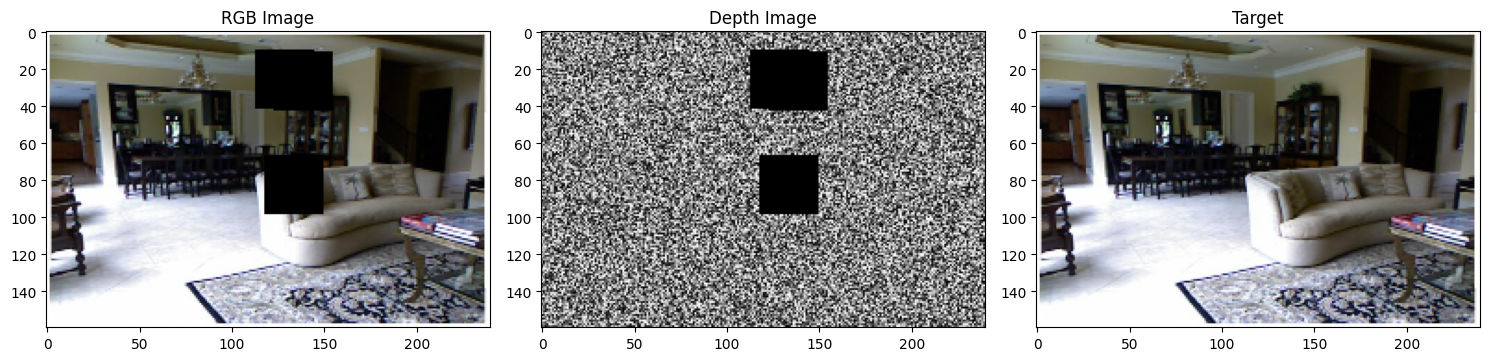

In [8]:
sample_batch = next(iter(train_loader))

print(sample_batch["rgb_input"].shape)            # Should be (batch_size, 4, H, W)
print(sample_batch["depth_input"].shape)          # Should be (batch_size, 3, H, W)
print(sample_batch["target"].shape)               # Should be (batch_size, 1, H, W) 

# Visualize first sample in the batch
show_sample(sample_batch, idx=0)

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = DepthEnhancedInpaintingNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.L1Loss()

num_epochs = 5
best_val_loss = float('inf')
for epoch in range(1, num_epochs+1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_dice = validate(model, val_loader, criterion, device)
    print(f"Epoch {epoch}/{num_epochs} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "nyu_inpainting.pth")
        print(f"Saved best model with Val Loss: {best_val_loss:.4f}")


mps


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample 0:
SSD between Inpainted vs GT: 72.711296
SSD between Masked vs GT: 1617.2625
Sample 1:
SSD between Inpainted vs GT: 116.920074
SSD between Masked vs GT: 4201.4243
Sample 2:
SSD between Inpainted vs GT: 72.94346
SSD between Masked vs GT: 2307.5144


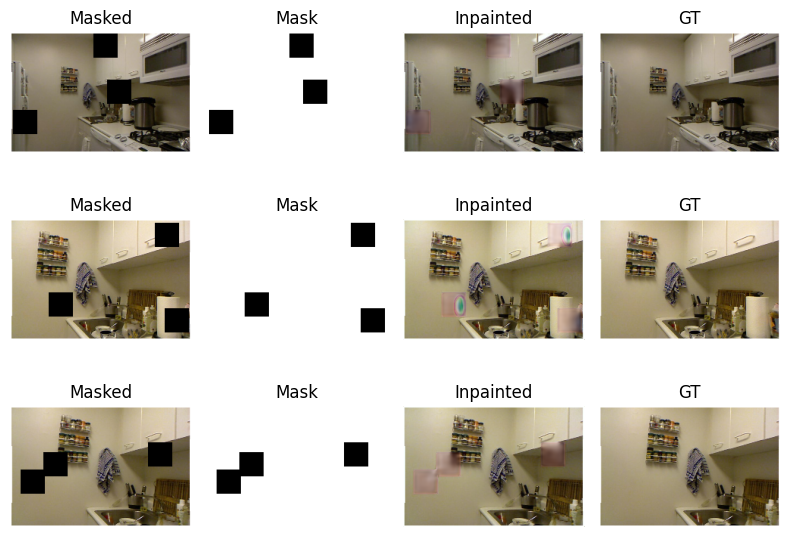

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = DepthEnhancedInpaintingNet().to(device)
model.load_state_dict(torch.load("nyu_inpainting.pth", map_location=device))
model.eval()

# Visualization: select a few samples from the test dataset.
sample_idx = 54
rows = 3
samples = [test_dataset[i] for i in range(sample_idx, sample_idx + rows)]
masked_images = torch.stack([s["rgb_input"] for s in samples], dim=0)
masks = torch.stack([s["mask"] for s in samples], dim=0)
sample_labels = torch.stack([s["target"] for s in samples], dim=0)

inpainted_images = []
with torch.no_grad():
    for i in range(rows):
        input_masked = masked_images[i].unsqueeze(0).to(device)
        input_mask = masks[i].unsqueeze(0).to(device)
        pred = model(input_masked, input_mask)
        inpainted_images.append(pred.squeeze(0).cpu())

fig, axs = plt.subplots(nrows=rows, ncols=4, figsize=(8, 2*rows))
for i in range(rows):
    # For display, we show only the RGB part (channels 0-2).
    masked_np = masked_images[i].permute(1, 2, 0).cpu().numpy()
    mask_np = masks[i].squeeze(0).cpu().numpy()
    inpainted_np = inpainted_images[i][:3].permute(1, 2, 0).cpu().numpy()
    gt_color = sample_labels[i].permute(1, 2, 0).cpu().numpy()

    # masked_np = np.clip(masked_np, 0, 1)
    # inpainted_np = np.clip(inpainted_np, 0, 1)
    # gt_color = np.clip(gt_color, 0, 1)

    print(f"Sample {i}:")
    print("SSD between Inpainted vs GT:", np.sum((inpainted_np - gt_color)**2))
    print("SSD between Masked vs GT:", np.sum((masked_np - gt_color)**2))
    
    axs[i, 0].imshow(masked_np)
    axs[i, 0].set_title("Masked")
    axs[i, 0].axis("off")
    
    axs[i, 1].imshow(mask_np, cmap="gray")
    axs[i, 1].set_title("Mask")
    axs[i, 1].axis("off")
    
    axs[i, 2].imshow(inpainted_np)
    axs[i, 2].set_title("Inpainted")
    axs[i, 2].axis("off")
    
    axs[i, 3].imshow(gt_color)
    axs[i, 3].set_title("GT")
    axs[i, 3].axis("off")
    
plt.tight_layout()
plt.show()

In [ ]:
ssd_inpainted_total = 0.0
ssd_masked_total = 0.0
num_images = 0

model.eval()
with torch.no_grad():
    for batch in test_loader:
        # Assume "rgb_input" is a (B, 4, H, W) tensor.
        # "target" is the ground truth RGB image (B, 3, H, W)
        rgb_input = batch["rgb_input"].to(device)
        mask = batch["mask"].to(device)
        gt = batch["target"].to(device)
        
        # Run the model to obtain the inpainted output.
        pred = model(rgb_input, mask)  # shape: (B, 3, H, W)
        
        # Extract the masked RGB from the input (first 3 channels).
        masked_rgb = rgb_input[:, :3, :, :]
        
        # Convert tensors to NumPy arrays.
        pred_np = pred.cpu().numpy()
        gt_np = gt.cpu().numpy()
        masked_np = masked_rgb.cpu().numpy()
        
        batch_size = pred_np.shape[0]
        for i in range(batch_size):
            ssd_inpainted = np.sum((pred_np[i] - gt_np[i])**2)
            ssd_masked = np.sum((masked_np[i] - gt_np[i])**2)
            ssd_inpainted_total += ssd_inpainted
            ssd_masked_total += ssd_masked
        
        num_images += batch_size

avg_ssd_inpainted = ssd_inpainted_total / num_images
avg_ssd_masked = ssd_masked_total / num_images

print("Average SSD (Inpainted vs GT):", avg_ssd_inpainted)
print("Average SSD (Masked vs GT):", avg_ssd_masked)